# **Neuro RLs** [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TomGeorge1234/NeuroRLTutorial/blob/main/NeuroRL.ipynb)
### **University of Amsterdam Neuro-AI Summer School ,2024**
#### made by: **Tom George (UCL) and Jesse Geerts (Imperial)**

In this tutorial we'll study and build reinforcement learning models inspired by the brain. 

TODO: Insert fun animation of the model we'll end up building 

## **Learning Objectives**

## **Contents** 
0. [Import dependencies and data](#dependencies)
1. [Rescorla-Wagner Model](#rescorla)
2. [Temporal Difference Learning](#td)
3. [Q-Learning](#q)
    1. [Navigating in a grid world](#grid)
4. [Deep Q-Learning](#dqn)
    1. [Neuroscience inspired basis functions](#basis)

---
## **0. Import dependencies and data** <a name="dependencies"></a>
Run the following code: It'll install some dependencies, download some files and import some functions. You can mostly ignore it. 

In [25]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
import wget 
#if running on colab we need to download the data and utils files
if os.path.exists("NeuroRL_utils.py"):
    print("utils located")
    pass
else: 
    wget.download("https://github.com/TomGeorge1234/NeuroRLTutorial/blob/main/NeuroRL_utils.py")
    print("...utils downloaded!")

from NeuroRL_utils import *
%load_ext autoreload
%autoreload 2

utils located


---
## **1. Rescorla-Wagner** <a name="rescorla"></a>

Classical conditioning is where a neutral stimulus -- also called the _unconditioned stimulus, US_ -- is paired with a response-producing stimulus -- _the conditioned stimulus, CS_. After the association is learned, the neutral stimulus *alone* can produce the response.

The most famous example is Pavlov's dogs: Pavlov rang a bell before feeding his dogs which would cause them to salivate. After a while, the dogs would start salivating when they heard the bell, even if no food was presented.

In 1972 Rescorla and Wagner proposed a simple model to explain this learning process. The model is based on the idea that the strength of the association between the CS and US is proportional to the discrepancy between the expected and actual US.

### **1.1. Model**
Following on from the Pavlov's dogs example, let's say the bell is the conditioned stimulus, $CS$, and the food is the unconditioned stimulus, $US$ which comes with a response (reward) of strength $R$. The _value_ of the stimulus, $V$, is the strength of the association between the $i^{th}$ stimulus and the unconditioned response.

Mathematically, the model is defined as follows:

$$\Delta V = \alpha \cdot \delta$$
$$\delta = R - V$$

I.e. the increment in the value of the stimulus, $\Delta V$, is proportional to the discrepancy between the reward (the unconditioned response) that was recieved, $R$, and the value of the stimulus, $V$. The proportionality constant $\alpha$ is the learning rate.

**Exercise 1.1** 
1. Consider a simple example where there is only one stimulus with zero initial value. A constant reward, $R$ is given each trial. Show the value of the stimulus after the first trial is given by $V(1) = \alpha  \cdot R$.
2. Show that $V(t) = R \cdot (1 - e^{-\alpha\cdot t})$  (_Hint: consider using the change of of variables $U(t) = R - V(t)$._)

### **1.2 Model implementation**

Below we provide some basic code implementing a Rescorla Wagner model. 

**Exercise 1.2**
1. Complete the `def learn(self, R, alpha):` function to implement the Rescorla-Wagner learning rule. 


In [26]:
class RescorlaWagner(BaseRescorlaWagner):
    def __init__(self, alpha = 0.1,): 
        """alpha is the learning rate"""
        self.V = 0 # initial value
        self.R_history = [None] # list to store the reward recieved on each trial
        self.V_history = [self.V] # list to store the predicted value on each trial
        super().__init__()

    def learn(self, R, alpha=0.1):
        """R is the reward recieved on the current trial, alpha is the learning rate"""
        raise NotImplementedError("You need to implement this method")
        # error = ???
        # self.V += ???
        # self.R_history.append(R)
        # self.V_history.append(V) 

In [3]:
def learn(self, R, alpha=0.1):
    """R is the reward recieved on the current trial, alpha is the learning rate"""
    error = R - self.V
    self.V += alpha * error
    self.R_history.append(R)
    self.V_history.append(self.V) 
RescorlaWagner.learn = learn # set the learn method to the function we just defined.


Now lets run an experiment where a reward of 1 is given each trial. We'll plot the value of the stimulus over time using the pre-written `RescorlaWagner.plot()` function.

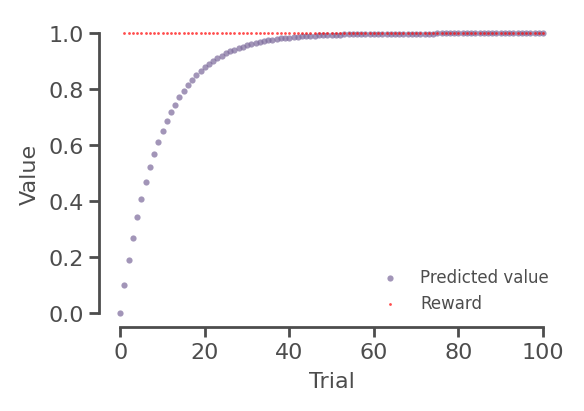

In [4]:
# Set your learning rate and reward
alpha = 0.1
R = 1

RW = RescorlaWagner()
for trial in range(100):
    RW.learn(R=R, alpha=alpha)
ax = RW.plot()

**Exercise 1.3**

Plot the theoretcial solution you derived earlier onto the `ax` and see if it fits.

In [5]:
# Your code goes here

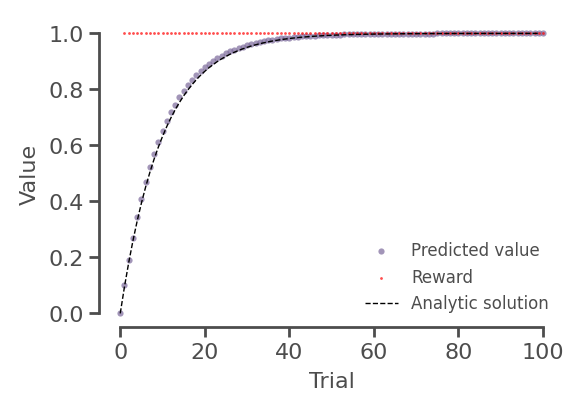

In [6]:
#@title Double click to see solution {display-mode: "form" }
t_range = np.arange(100)
R = 1
alpha = 0.1
V = R * (1 - np.exp(-t_range*alpha))
ax.plot(t_range, V, label='Analytic solution', linewidth=0.5, color='k', linestyle='--')
ax.legend()
ax.figure

**Exercise 1.4**

1. **Acquisition** Repeat the above experiment with a lower and a higher learning rate. What do you observe?
2. **Extinction** Repeat the above but this time reward is given only for the first 50 trials, then the reward is set to zero. What do you observe?


Text(0.5, 1.0, 'Extinction experiment')

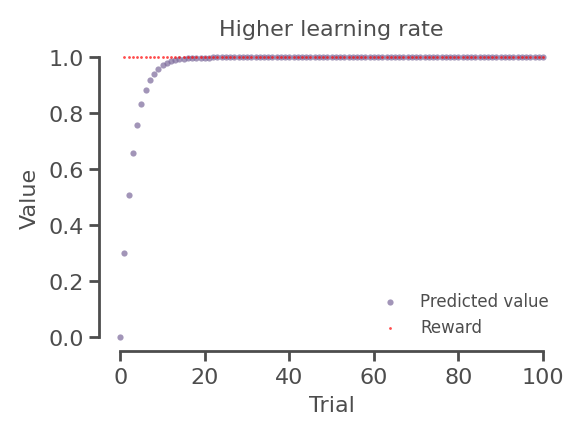

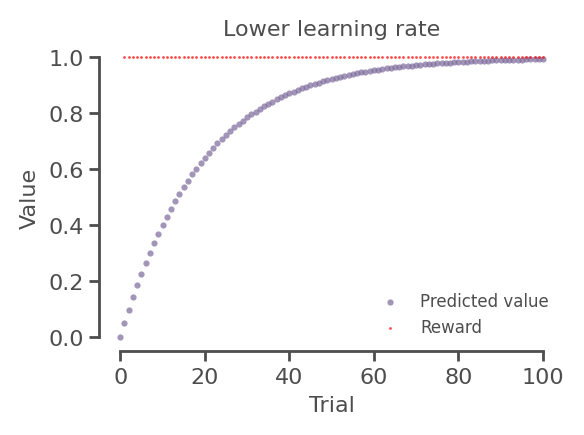

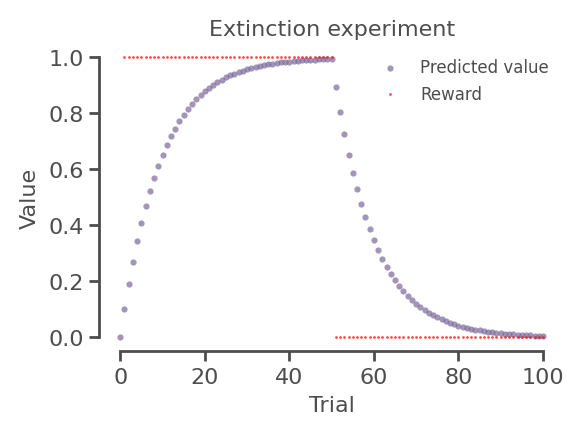

In [7]:
alpha = 0.3
R = 1
RW = RescorlaWagner()
for trial in range(100):
    RW.learn(R=1, alpha=alpha)
ax = RW.plot()
ax.set_title("Higher learning rate")

# Set your learning rate and reward
alpha = 0.05
R = 1
RW = RescorlaWagner()
for trial in range(100):
    RW.learn(R=1, alpha=alpha)
ax = RW.plot()
ax.set_title("Lower learning rate")


# Set your learning rate and reward
alpha = 0.1
R = 1
RW = RescorlaWagner()
for trial in range(50):
    RW.learn(R=1, alpha=alpha)
for trial in range(50):
    RW.learn(R=0, alpha=alpha)
ax = RW.plot()
ax.set_title("Extinction experiment")

### **1.3. Rescorla-Wagner with multiple unconditioned stimuli**

It's easy to extend the Rescorla-Wagner model to multiple stimuli:

* Multiple stimuli are represented by a vectors, e.g.:  
    * Stimulus A: $S = [1, 0]$ means there are 2 stimuli, only the first of which was present on this particular trial. 
    * Stimulus B: $S = [0, 1]$ means only the second stimulus was present.
    * Stimulus A & B: $S = [1, 1]$ means both stimuli were present.
* A vector of association "weights", $W$, denotes the strength of the association between each stimulus and the unconditioned response (i.e. the value of each stimulus). 
    * $W = [W_1, W_2]$.
* The total value of the stimuli is the sum of the values of each stimulus present on a given trial: 
$$ V = S \cdot W $$

The full Rescorla-Wagner model is then:
$$\delta \vec{W} = \alpha \cdot \big(R - V\big) \cdot \vec{S}$$

**Exercise 1.5**
1. Reason why $\vec{S}$ now appears in the learning rule.

**Exercise 1.6**
As before, complete the `def learn(self, R, S, alpha):` function to implement the Rescorla-Wagner learning rule for multiple stimuli.

In [11]:
class RescorlaWagner_MultipleStimuli(BaseRescorlaWagner):
    def __init__(self, alpha = 0.1, n_stimuli=2): 
        """alpha is the learning rate"""
        self.W = np.zeros(n_stimuli)
        self.W_history = np.array([self.W])
        self.R_history = [None]
        self.V_history = [0]
        super().__init__(n_stimuli=n_stimuli)

    def learn(self, S, R, alpha=0.1):
        """S is the stimulus vector. R is the reward recieved on the current trial"""
        V = S @ self.W
        error = R - V
        self.W += alpha * S * error

        # store the history
        self.W_history = np.vstack([self.W_history, self.W])
        self.R_history.append(R)
        self.V_history.append(S @ self.W)
        

**Exercise 1.7**:
1. With your partner implement these four experiments in the Rescorla-Wagner model:
    1. **Blocking**
        * A single stimulus is paired with the US (A --> R), then a compound stimulus is paired with the US (AB --> R). What happens?
    2. **Overshadowing**
        * Two stimuli are paired with a reward (AB --> R) but one is much more salient than the other, e.g. $\vec{S} = [1, 0.1]$.
    3. **Overexpectation**
        * Two stimuli are seperately paired with the US (A --> R, B --> R), then the compound stimulus is presented (AB --> ?). What happens?
    4. **Conditioned Inhibition**
        * A single stimulus is paired with the US (A --> R) then a second stimulus is added and the reward is removed. (AB --> _). What do you observe?

In [12]:
# Your code for the blocking experiment goes here

[9.99986719e-01 1.32806994e-05]


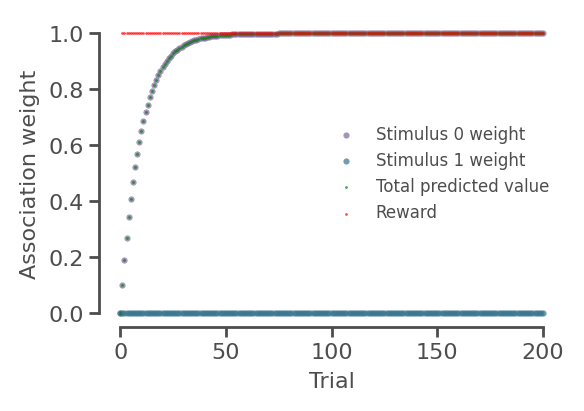

In [13]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_MultipleStimuli(n_stimuli=2)
for i in range(100):
    RW.learn(S=np.array([1, 0]), R=1)
for i in range(100):
    RW.learn(S=np.array([1, 1]), R=1)
RW.plot()
print(RW.W)

In [14]:
# Your code for the overshadowing experiment goes here

[1.09734977 0.12192775]


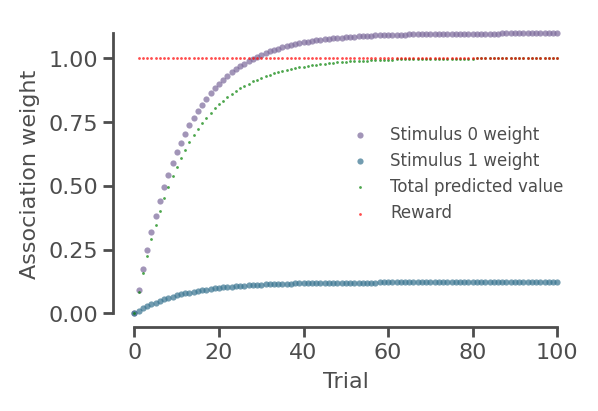

In [15]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_MultipleStimuli(n_stimuli=2)
for i in range(100):
    RW.learn(S=np.array([0.9, 0.1]), R=1)
RW.plot()
print(RW.W)

In [16]:
# Your code for the overexpectation experiment goes here

[0.50000706 0.50000706]


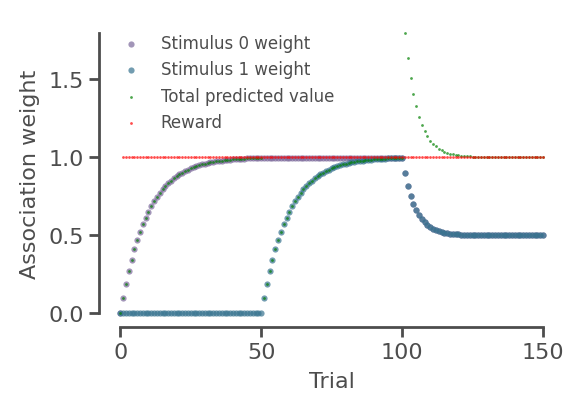

In [17]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_MultipleStimuli(n_stimuli=2)
for i in range(50):
    RW.learn(S=np.array([1, 0]), R=1)
for i in range(50):
    RW.learn(S=np.array([0, 1]), R=1)
for i in range(50):
    RW.learn(S=np.array([1, 1]), R=1)
RW.plot()
print(RW.W)

In [18]:
# Your code for the inhibition experiment goes here

<Axes: xlabel='Trial', ylabel='Association weight'>

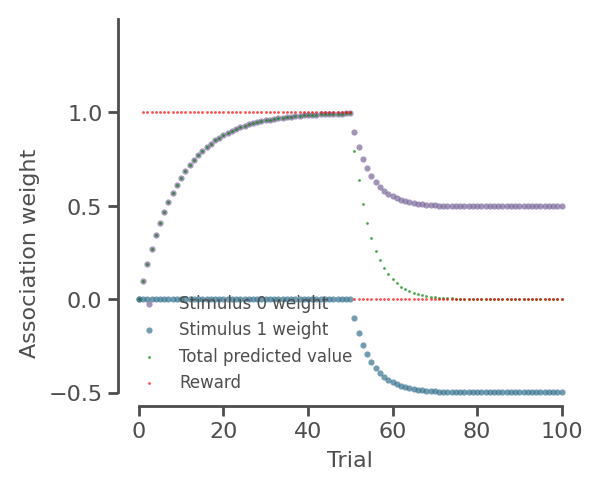

In [19]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_MultipleStimuli(n_stimuli=2)
for i in range(50):
    RW.learn(S=np.array([1, 0]), R=1)
for i in range(50):
    RW.learn(S=np.array([1, 1]), R=0)
RW.plot()

---
## **2. Temporal difference learning** <a name="td"></a>

One limitation of the Rescorla-Wagner model is that it doesn't take into account the temporal structure of the environment. Associations are made between stimuli _now_ and rewards _now_. In reality, rewards are often delayed.

Temporal difference (TD) learning takes into account the temporal structure of the environment. As you learnt in today's lecture the idea is that "value" of a state is based not only on the reward recieved _now_ but on all the rewards that _will be_ recieved in the future.

$$V(S_t) = R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \ldots$$

### Monte-Carlo learning
One way to estimate the value of a state is to wait until the end of the episode, sum all the rewards that were recieved, and compare this to the cu. This is called Monte-Carlo learning.

**Exercise 2.1**
1. Show that the value of a state can be written as the sum of the reward recieved at that state and the value of the next state. I.e.
$$V(S_t) = R_t + \gamma V(S_{t+1}).$$


In [21]:
class TDLearner(BaseTDLearner):
    def __init__(self, gamma=0.5, n_states=10):
        """TD learner class. 
        Args:
            gamma (float): discount factor
            n_states (int): number of distinct states in the environment"""
        self.V = np.zeros(n_states)
        self.S_prev = None
        self.gamma = gamma
        #History data (for plotting) 
        self.V_history = [self.V.copy()]
        self.S_history = [0]
        self.R_history = [None]
        self.TDError_history = [None]

    def learn(self, S, R, alpha=0.1):s
        """S is the state index, an integer between 0 and n_states-1 specifying the current state. R is the reward recieved on the current trial"""

        if self.S_prev is None: 
            TD_error = R + self.gamma * self.V[S] - self.V[self.S_prev]
            self.V[self.S_prev] = self.V[self.S_prev] + alpha * TD_error

        self.S_prev = S
        self.V_history.append(self.V.copy())
        self.S_history.append(S)
        self.R_history.append(R)

N_trials = 100
TD = TDLearner()
for trial in range(N_trials):
    for S in range(10):
        if S != 9: R = 0
        elif S == 9: R = 1
        TD.learn(S=S, R=R)
    TD.S_prev = None # reset the previous state to None to indicate the end of the trial

array([<Axes: title={'center': 'Value function'}, ylabel='State'>,
       <Axes: xlabel='Trial', ylabel='State'>], dtype=object)

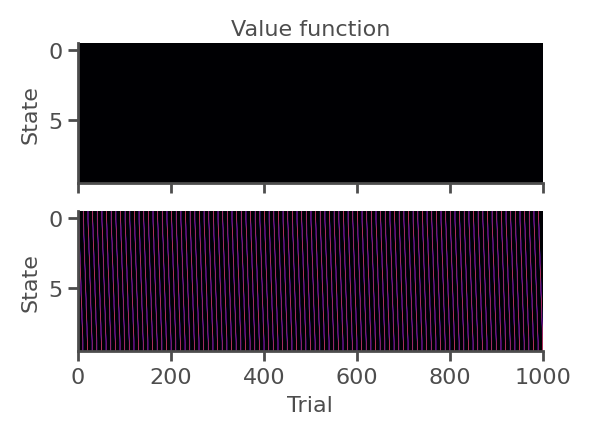

In [22]:
TD.plot()

In [261]:
TD.V

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])